# Space-time partial differential equation: Study of the diffusive equation (implicit methods)

In [1]:
# Importing relevant libraries 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# plt.style.use('dark_background')
plt.style.use('default')

def u(x, A=0.3): 
    """ 
    Initial condition for t=t0 when a = const

    Parameters
    ----------
    x : `array`
        Spatial axis. 
    A : `float`
        A constant of the initial condition (default = 0.02).
    
    Returns
    -------
    Equation 2
    """
    W = 0.1 
    x0 = 0
    return A*np.exp(-(x - x0)**2 / W**2)
    
x0 = -2.6 
xf = -x0

Let's consider now the viscous term in Burger's equation: 

$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}, \tag{1}$$

## 1- Apply an explicit method. 

What would be the CFL condition for a viscous term where $\nu$ is either a constant or an array that depends on $x$. We would like to solve equation (1) numerically for $x  [x_0, x_f]$ with $x_0 = −2.6$, $x_f = 2.6$, periodic boundary conditions and with the initial condition:

$$u(x,t=t_0) = A\exp(-(x-x_0)^2/W^2)   \tag{2}$$

with $A=0.3$, $W=0.1$, and $x_0=0$. __Suggestion__: Apply the first derivative upwind and the second downwind. Apply Von Newman analysis. Is it stable? What is the time-step dependence with $\Delta x$? 

<span style="color:pink">

NEW! Added derivative that does upwind / downwind scheme 

</span>

In [2]:
def deriv_up_down(xx, hh): 
    """
    Returns the 
    """
    dx = xx[1] - xx[0]
    return (np.roll(hh, -1) - 2*hh + np.roll(hh, 1))/dx**2

<span style="color:pink">
We begin by applying the upwind and downwind derivative such that 

$$
\frac{u_j^{n+1} - u_j^n}{\Delta t} = \nu\frac{(u_{j+1}^n - 2u_j^n + u_{j-1}^n)}{\Delta x^2}
$$

Next, we apply Von-Newman analysis, 

$$
u_j^n = \xi^n e^{ikj\Delta x}, 
$$

which makes 

$$
e^{ikj\Delta x} \frac{\xi^{n+1} - \xi^n}{\Delta t} = \nu\xi^n e^{ikj\Delta x} \frac{e^{ik\Delta x} - 2 + e^{-ik\Delta x}}{\Delta x^2}. 
$$

We divide by $e^{ikj\Delta x}$ on both sides, to eliminate the term. 

$$
\frac{\xi^{n+1} - \xi^n}{\Delta t} = \nu\xi^n \frac{e^{ik\Delta x} - 2 + e^{-ik\Delta x}}{\Delta x^2}. 
$$

Next, we can rewrite the equation using that $e^{i\theta} = \cos\theta + i\sin\theta$, to get 

$$
\xi = 4\frac{\nu\Delta t}{\Delta x^2} \sin^2\left(\frac{k\Delta x}{2}\right) + 1.
$$

Requiering that $|\xi^n|^2 \leq 1$ for all $k$ means that 

$$
\left(4\frac{\nu\Delta t}{\Delta x^2} \sin^2\left(\frac{k\Delta x}{2}\right) + 1\right)^2 \leq 1
$$

This holds for all $k$ when, 

$$
\frac{16\nu^2\Delta t^2}{\Delta x^4} - \frac{4\nu\Delta t}{\Delta x^2} + 1 \leq 1 \\ 
\frac{16\nu^2\Delta t^2}{\Delta x^4} \leq \frac{4\nu\Delta t}{\Delta x^2} \\ 
\frac{4\nu\Delta t}{\Delta x^2} \leq 1, 
$$

making the CFL condition 

$$
\Delta t \leq \frac{\Delta x^2}{4\nu}. 
$$


</span>

How many steps are needed to reach a $t=1.8$ for $nump=128$? And $256$? 

In [3]:
# # Initialize xx, t and unnt 
# # nump = 128 
# nump = 256 
# xx = np.arange(nump)/(nump-1.0) * (xf - x0) + x0
# nt = 200 

# t, unnt_Lax = nm.evolv_Lax_uadv_burgers(xx, u(xx), nt, cfl_cut=0.98)

# # Animation 
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# def init(): 
#     xx,unnt_Lax[:,0]
#     # axes.plot(xx,unnt[:,0])

# def animate(i):
#     axes.clear()
#     axes.plot(xx,unnt_Lax[:,i])
#     axes.set_title('t=%.2f'%t[i])
#     axes.set_ylim((0,0.31))
#     axes.grid(True)

# anim = FuncAnimation(fig, animate, interval=1, frames=nt, init_func=init)
# plt.close()
# HTML(anim.to_jshtml())

## Choose one of the following options: 

## 2- Implicit methods.

In the [wiki](https://github.com/AST-Course/AST5110/wiki/Implicit-methods), we describe some implicit or semi-explicit methods that allow relaxing the CFL constraint on diffusive terms. Consider Newton-Rapson method and repeat the previous numerical experiment. For this, you will need to implement the following   


$F_j = u^{n+1}_j - u^n_j - \nu \, (u^{n+1}_{j+1} - 2u^{n+1}_{j}+u^{n+1}_{j-1})\frac{\Delta t}{\Delta x^2}$

in `NR_f` and `step_diff_burgers` functions in `nm_lib`. 

And the Jacobian can be easily built. 

$J(j,k) = F_j'(u^{n+1}_k)$

fill in the `jacobian` function in `nm_lib`. Note that this matrix is linear with $u$. 

In [4]:
# ##Initialize xx, t and unnt 
# nint = 128
# nump = nint + 1
# xx = np.arange(nump)/(nump-1.0) * (xf - x0) + x0

# nt = 200 
# a = 1
# dt = 0.01
# t, unnt, errt, countt = nm.Newton_Raphson(xx, u(xx), a, dt, nt, bnd_limits=[1,1], bnd_type='wrap')

In [5]:
# # Animation 
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# def init(): 
#     xx,unnt[:,0]
#     # axes.plot(xx,unnt[:,0])

# def animate(i):
#     axes.clear()
#     axes.plot(xx,unnt[:,i])
#     axes.set_title('t=%.2f'%t[i])
#     # axes.set_ylim((0,0.35))
#     axes.grid(True)

# anim = FuncAnimation(fig, animate, interval=1, frames=nt, init_func=init)
# plt.close()
# HTML(anim.to_jshtml())

Test the model with [wiki](https://github.com/AST-Course/AST5110/wiki/Self-similar-solution-for-parabolic-eq) self-similar solutions. How long it takes each time step compared to the Lax-method? Use `time.time` library. Do it for nump=256, nt=30 and dt = 0.1. In order to test the simulation, use `curve_fit` from `scipy.optimize`. 

__hint__ consider to use a good initial guess (`p0`) in and `bnd_limits` to facilitate the fitting wiht `curve_fit`. What happens to the solution when increasing dt? How much can be improved in limiting the tolerance?

----------------------------------------------

Let's consider a non-linear function where $\nu$ depends on $u$. To keep it simple, solve the following: 

$\frac{\partial u}{\partial t} = u \frac{\partial^2 u}{\partial x^2}$

where $\nu_0$ is a constant and the same initial conditions as the previous exercise (fill in `Newton_Raphson_u`, `jacobian_u` and `NR_f_u`. Consider an error limit of $10^{-4}$ and compare the previous exercise (with the same error limit). How many iterations needs now the method to converge to the right solution? Why? Increase `ncount` to 1000. 

## 3- Semi-explicit methods. 

__a)__ Super-time-stepping (STS) schemes work for parabolic terms. STS is an API method that performs a subset of "unstable" intermediate steps, but the sum of all the steps is stable. Visualize how `taui_sts` varies with $nu$ and $niter$. Compare the solution with the analytical one for the final and intermediate STS steps. For the full STS steps, how improves the solution with $nu$? and $niter$? Is there a relation between the error and these two parameters, $nu$, and $niter$? For which $niter$ and $nu$ the method provides larger steps than an ordinary explicit. For this exercise, fill in `evol_sts`, and `taui_sts`. 

<span style="color:pink">

We begin by visualizing how `taui_sts` varies with $\nu$. 

</span>

0.5002499029741536
0.5002082351322684
0.500138804152245
0.5000693924441632
0.5000277546665082


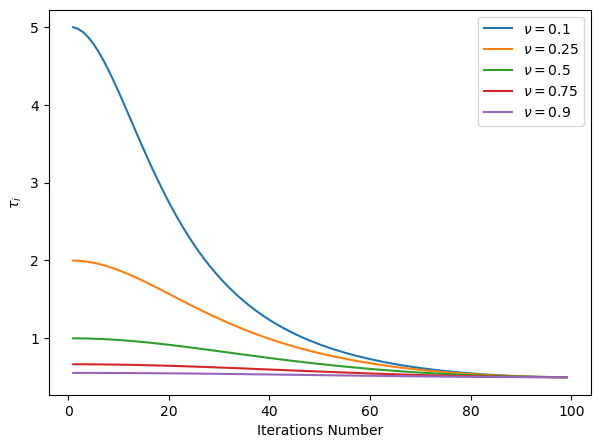

In [6]:
## Visualize how taui_sts varies with nu, as a function of iiter 

# Initialize 
iiter = np.arange(1, 100) # array of integers 
niter = 100 # number of iterations, Constant 
nu = [0.1, 0.25, 0.5, 0.75, 0.9] # Coefficient between (0,1)

# Arrays for plotting 
taui_nu_01 = np.zeros(len(iiter))
taui_nu_025 = np.zeros(len(iiter))
taui_nu_05 = np.zeros(len(iiter))
taui_nu_075 = np.zeros(len(iiter))
taui_nu_09 = np.zeros(len(iiter))

for i in range(len(iiter)): 
    taui_nu_01[i] = nm.taui_sts(nu[0], niter, iiter[i])
    taui_nu_025[i] = nm.taui_sts(nu[1], niter, iiter[i])
    taui_nu_05[i] = nm.taui_sts(nu[2], niter, iiter[i])
    taui_nu_075[i] = nm.taui_sts(nu[3], niter, iiter[i])
    taui_nu_09[i] = nm.taui_sts(nu[4], niter, iiter[i])

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(iiter, taui_nu_01,  label=rf"$\nu = {nu[0]}$")
ax.plot(iiter, taui_nu_025, label=rf"$\nu = {nu[1]}$")
ax.plot(iiter, taui_nu_05,  label=rf"$\nu = {nu[2]}$")
ax.plot(iiter, taui_nu_075, label=rf"$\nu = {nu[3]}$")
ax.plot(iiter, taui_nu_09,  label=rf"$\nu = {nu[4]}$")
ax.set_xlabel("Iterations Number")
ax.set_ylabel(r"$\tau_i$")
plt.legend()

print(taui_nu_01[-1])
print(taui_nu_025[-1])
print(taui_nu_05[-1])
print(taui_nu_075[-1])
print(taui_nu_09[-1])

<span style="color:pink">

For a constant number of iterations set to 100, $\tau_i$ will decrease as the iteratons number increases, converging towards 0.5. For varying $\nu$, we see how $\tau_i$ begins at a higher value for a lower $\nu$. 

Next, we want to visualize how `taui_sts` varies with $niter$. 

</span>

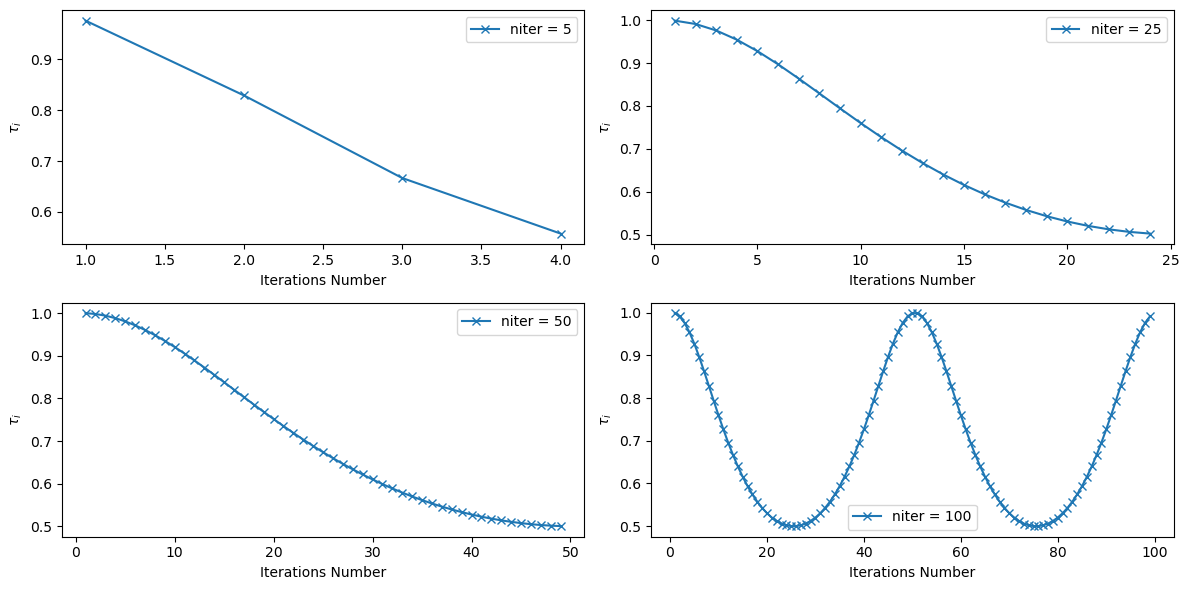

In [7]:
## Visualize how taui_sts varies with niter, as a function of iiter

# Initialize
nu = 0.5 # Coefficient between (0,1), constant
niter = [5, 25, 50, 100] # number of iterations
iiter5   = np.arange(1, niter[0])
iiter25  = np.arange(1, niter[1])
iiter50  = np.arange(1, niter[2])
iiter100 = np.arange(1, niter[3])

# Arrays for plotting 
taui_it_5 = nm.taui_sts(nu, niter[0], iiter5)
taui_it_25 = nm.taui_sts(nu, niter[1], iiter25)
taui_it_50 = nm.taui_sts(nu, niter[2], iiter50)
taui_it_100 = nm.taui_sts(nu, niter[1], iiter100)

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12, 6))

axes[0,0].plot(iiter5, taui_it_5, marker='x', label=rf"niter = {niter[0]}")
axes[0,1].plot(iiter25, taui_it_25, marker='x', label=rf"niter = {niter[1]}")
axes[1,0].plot(iiter50, taui_it_50, marker='x', label=rf"niter = {niter[2]}")
axes[1,1].plot(iiter100, taui_it_100, marker='x', label=rf"niter = {niter[3]}")         

for i in range(2):
    for j in range(2):
        # axes[i,j].grid(True)
        axes[i,j].set_xlabel("Iterations Number")
        axes[i,j].set_ylabel(r"$\tau_i$")
        axes[i,j].legend()

plt.tight_layout()

<span style="color:pink">

As the number of iterations increase, the curve becomes smoother due to the increases number of steps making each step smaller. 

After filling in `evol_sts`, we compare the solution with the analytical one for the final and intermediate STS steps. 
In order to do this we will use a Gaussian function and fit this to the STS curve. 

</span>

In [8]:
def gaussian(xx, A, mu, sigma, C): 
    """
    Gaussian function

    Parameters
    ----------
    xx : `array`
        Spatial axis. 
    A : `float`
        Amplitude. 
    mu : `float`
        Expected value. 
    sigma : `float`
        Standard deviation. 
    C : `int` or `float`
        Constant. 
    Returns 
    -------
    `array`
        Gaussian function
    """
    return A * np.exp(-0.5*(xx - mu)**2 / (sigma**2)) + C    

In [9]:
nump = 126
xx = np.arange(nump)/(nump-1.0) * (xf-x0) + x0
nt = 2000 

t_sts, unnt_sts = nm.evol_sts(xx, u(xx), nt, a=1, ddx=deriv_up_down, bnd_limits=[1,1], nu=0.1, n_sts=10)

# Using curve fit for the gaussian fit 
from scipy.optimize import curve_fit

In [10]:
# Initialize arrays for fitting
Amplitude = np.zeros(nt)
mu = np.zeros(nt)
sigma = np.zeros(nt)
C = np.zeros(nt)

for i in range(nt): 
    popt, pcov = curve_fit(gaussian, xx, unnt_sts[:,i]) # optimal values, covariance matrix

    Amplitude[i] = popt[0]
    mu[i]        = popt[1]
    sigma[i]     = popt[2]
    C[i]         = popt[3]

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<span style="color:pink">

From the [wiki](https://github.com/AST-Course/AST5110/wiki/Self-similar-solution-for-parabolic-eq) we have that for this case, 

$$
u \propto t^{-1/2}, 
$$

and 

$$
R \propto t^{1/2}. 
$$

We combine these expressions with the amplitude (height of $u$) and standard deviation (width of $u$), respectively. 

</span>

0.30000000001318194
(2000,)


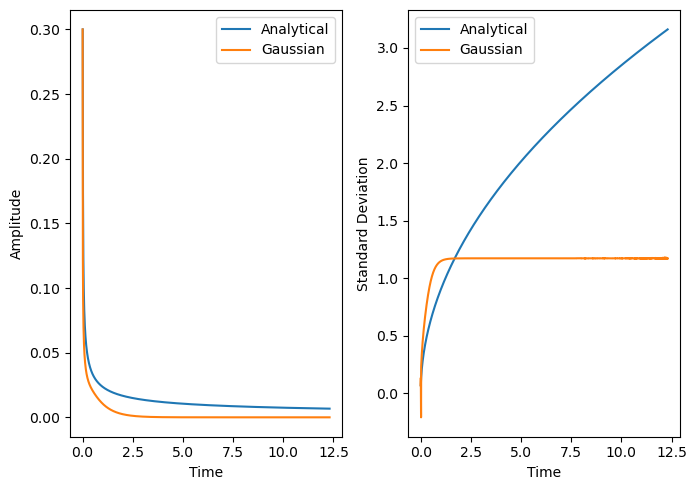

In [11]:
# Coefficients for analytical solution: 
A_max       = Amplitude[0] * t_sts[1:]**(-0.5)/t_sts[1]**(-0.5)
sigma_coeff = sigma[0]     * t_sts[1:]**( 0.5)/t_sts[1]**( 0.5)

print(Amplitude[0])
print(Amplitude.shape)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.plot(t_sts[1:], A_max, label="Analytical")
ax2.plot(t_sts[1:], sigma_coeff, label="Analytical")


ax1.plot(t_sts, Amplitude, label="Gaussian")
ax1.set(xlabel="Time", ylabel="Amplitude")
ax1.legend()

ax2.plot(t_sts, sigma, label="Gaussian")
ax2.set(xlabel="Time", ylabel="Standard Deviation")
ax2.legend()

plt.tight_layout()

(1999,)
0.30000000001318194
(2000,)


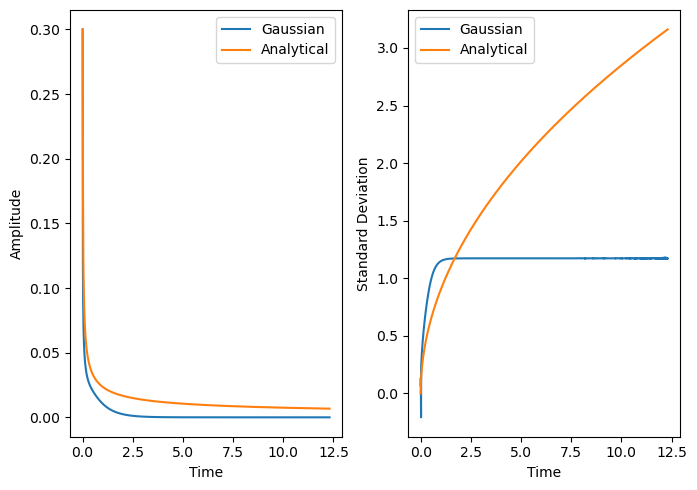

In [12]:
A_max       = Amplitude[0] * t_sts[1:]**(-0.5)/t_sts[1]**(-0.5)
print(A_max.shape)
sigma_coeff = sigma[0] * t_sts**(0.5)/t_sts[1]**(0.5)

print(Amplitude[0])

print(Amplitude.shape)
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.plot(t_sts, Amplitude, label="Gaussian")
ax1.plot(t_sts[1:], A_max, label="Analytical")
ax1.set(xlabel="Time", ylabel="Amplitude")
ax1.legend()

ax2.plot(t_sts, sigma, label="Gaussian")
ax2.plot(t_sts, sigma_coeff, label="Analytical")
ax2.set(xlabel="Time", ylabel="Standard Deviation")
ax2.legend()

plt.tight_layout()

<span style="color:pink">

There is a bug in the sts method. I am lookjin for it

We animate the analytical solution with the STS to see how they compare. 

</span>

In [13]:
# # Animation 
# N = 100 
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# def init(): 
#     axes.plot(xx, unnt_sts[:,0])
#     axes.plot(xx, gaussian(xx, A_max*t_sts[0]**(-0.5), 0, sigma_coeff*t_sts[0]**0.5, 0))

# def animate(i):
#     axes.clear()
#     axes.plot(xx, unnt_sts[:,::10][:,i], label='sts')
#     unnt_gauss = gaussian(xx, A_max*t_sts[::10][i]**(-0.5), 0, sigma_coeff*t_sts[::10][i]**0.5, 0)
#     axes.plot(xx, unnt_gauss, label='gauss')
#     axes.legend()
#     axes.set_ylim((0, 0.31))
#     axes.set_title('t=%.2f'%t_sts[::10][i])
#     axes.grid(True)
    
# anim = FuncAnimation(fig, animate, interval=50, frames=len(t_sts[::10]), init_func=init)
# plt.close()
# HTML(anim.to_jshtml())

<span style="color:pink">

Cannot be trusted when the other plots are so strange!!!! 

First timestep is nonexistent?? where is gauss 0. 

Then the fit is pretty good for a while

Then it gets bad. Super diffusive. 


Notes: It is interesting to analyze timesteps (what happens inbetween and how does this depend on substeps?)

</span>